<a href="https://colab.research.google.com/github/vedantgadhvi/Customer-Churn-Prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Prediction Project

This notebook predicts customer churn using machine learning models and interprets results using SHAP values.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
import warnings
warnings.filterwarnings("ignore")


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Customer Churn Prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df.drop(['customerID'], axis=1, inplace=True)
df = pd.get_dummies(df, drop_first=True)
df.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [5]:
df['ServicesCount'] = df[['PhoneService_Yes', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
                          'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes']].sum(axis=1)
df['AvgMonthlySpend'] = df['TotalCharges'] / (df['tenure'] + 1)
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 60, 72], labels=[1, 2, 3, 4, 5])
df['ChargesPerService'] = df['MonthlyCharges'] / (df['ServicesCount'] + 1)
df['HighValueCustomer'] = (df['MonthlyCharges'] > 80).astype(int)
df['LongTermCustomer'] = (df['tenure'] > 60).astype(int)
df = pd.get_dummies(df, columns=['TenureGroup'], drop_first=True)
df.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,PaymentMethod_Mailed check,ServicesCount,AvgMonthlySpend,ChargesPerService,HighValueCustomer,LongTermCustomer,TenureGroup_2,TenureGroup_3,TenureGroup_4,TenureGroup_5
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,1,14.925000,14.9250,0,0,False,False,False,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,True,3,53.985714,14.2375,0,0,False,True,False,False
2,0,2,53.85,108.15,1,True,False,False,True,False,...,True,3,36.050000,13.4625,0,0,False,False,False,False
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,3,40.016304,10.5750,0,0,False,True,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,1,50.550000,35.3500,0,0,False,False,False,False


In [6]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))


Random Forest Accuracy: 0.7842441447835344
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [8]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))


XGBoost Accuracy: 0.7771469127040455
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.59      0.52      0.56       374

    accuracy                           0.78      1409
   macro avg       0.71      0.70      0.70      1409
weighted avg       0.77      0.78      0.77      1409



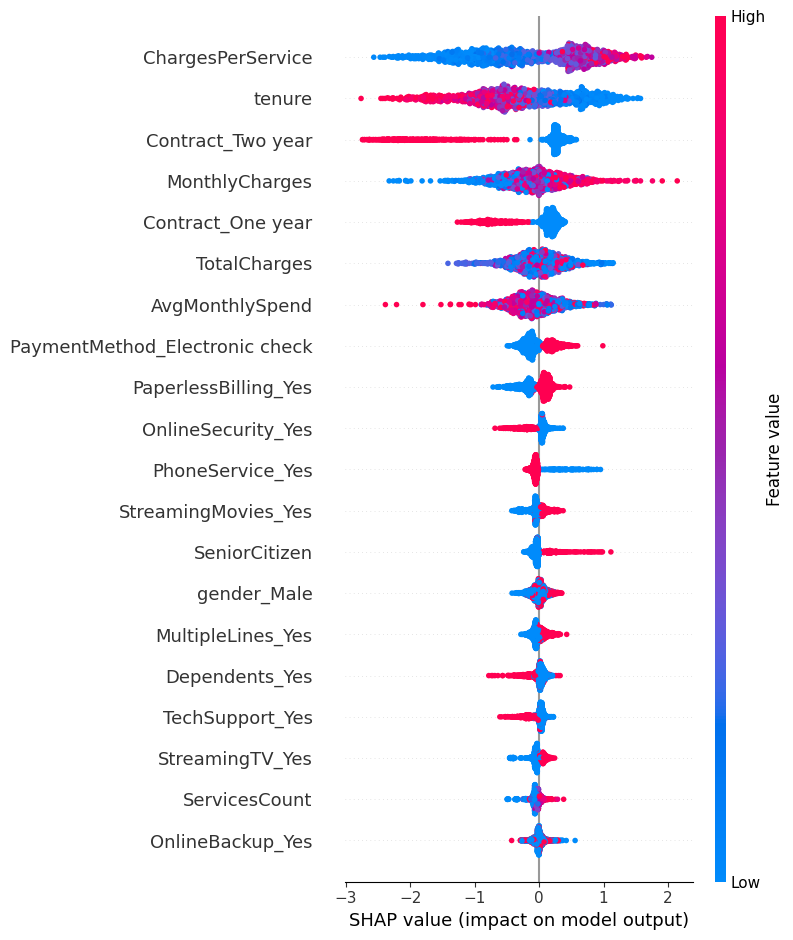

In [9]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)
